In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gdown

In [2]:
#note: remove the hash below and install the gdown library if not installed already 

In [3]:
#conda install -c conda-forge gdown

In [4]:
#note: remove the hash below and install the category_encoders library if not installed already

In [5]:
#conda install -c conda-forge category_encoders

In [6]:
#download the csv from google drive using gdown library
url = "https://drive.google.com/u/2/uc?id=1tGGV3sGKtz0AHeGcuRUsTvirHhQIoPjt&export=download"
output = "nyc_accidents.csv"
gdown.download(url, output)

Downloading...
From: https://drive.google.com/u/2/uc?id=1tGGV3sGKtz0AHeGcuRUsTvirHhQIoPjt&export=download
To: C:\Users\mhaye\OneDrive - Edinburgh Napier University\Dissertation\Code\nyc_accidents.csv
100%|█████████████████████████████████████████████████████████████████████████████| 10.3M/10.3M [00:00<00:00, 27.4MB/s]


'nyc_accidents.csv'

In [7]:
df = pd.read_csv('./nyc_accidents.csv')
df

,CRASH_DATE,CRASH_TIME,PERSON_INJURY,PERSON_AGE,BODILY_INJURY,SAFETY_EQUIPMENT,PERSON_SEX,PERSON_TYPE,PED_LOCATION,CONTRIBUTING_FACTOR_2,...,COMPLAINT,EMOTIONAL_STATUS,VEHICLE_ID,PERSON_ID,CONTRIBUTING_FACTOR_1,POSITION_IN_VEHICLE,PED_ROLE,UNIQUE_ID,PED_ACTION,COLLISION_ID
0,2021-05-02,21:00,Killed,62.0,Head,NaN,F,Pedestrian,Pedestrian/Bicyclist/Other Pedestrian at Inter...,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,...,Severe Bleeding,Apparent Death,NaN,f2f329b6-2dfc-4bd0-b751-2e4255f1ea06,Traffic Control Disregarded,NaN,Pedestrian,11791937,Crossing Against Signal,4412948
1,2021-05-21,0:00,Killed,24.0,Entire Body,Air Bag Deployed,M,Occupant,NaN,NaN,...,Internal,Apparent Death,19986231.0,e27e12a2-0485-4e22-b692-3f8a765d2582,NaN,Driver,Driver,11819198,NaN,4419608
2,2021-10-15,2:00,Killed,30.0,Head,None,M,Occupant,NaN,NaN,...,Internal,Apparent Death,20091024.0,1a6f5aa7-5125-4be2-8499-fe7977cb0d90,NaN,Driver,Driver,11998317,NaN,4467504
3,2021-04-17,13:00,Killed,71.0,Head,NaN,M,Pedestrian,Pedestrian/Bicyclist/Other Pedestrian Not at I...,Unspecified,...,Internal,Unconscious,NaN,b950706b-00a4-485c-84c5-777208cc3cc9,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,NaN,Pedestrian,11745791,"Crossing, No Signal, or Crosswalk",4408062
4,2021-05-25,22:00,Killed,69.0,Entire Body,NaN,F,Pedestrian,Pedestrian/Bicyclist/Other Pedestrian Not at I...,Unspecified,...,None Visible,Conscious,NaN,6504ea0a-c92d-444c-8127-284943be9aac,Unspecified,NaN,Pedestrian,11991283,"Crossing, No Signal, Marked Crosswalk",4420918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45664,2021-05-07,0:00,Injured,24.0,Back,Lap Belt & Harness,M,Occupant,NaN,NaN,...,Complaint of Pain or Nausea,Conscious,19988552.0,051c2721-1533-4f48-bda4-273bd3725242,NaN,Driver,Driver,11823105,NaN,4414130
45665,2021-04-27,13:00,Injured,29.0,Knee-Lower Leg Foot,Lap Belt & Harness,M,Occupant,NaN,NaN,...,Complaint of Pain or Nausea,Conscious,19966687.0,017e3824-4cbe-409a-ba57-e741923a60a1,NaN,Driver,Driver,11785808,NaN,4411119
45666,2021-05-07,14:00,Injured,7.0,Head,Child Restraint Only,F,Occupant,NaN,NaN,...,Complaint of Pain or Nausea,Conscious,19951136.0,c70e93ff-cb5f-4e15-b888-0f17a1ede0cd,NaN,"Left rear passenger, or rear passenger on a bi...",Passenger,11758963,NaN,4415414
45667,2021-05-10,16:00,Injured,13.0,Elbow-Lower-Arm-Hand,None,F,Occupant,NaN,NaN,...,Complaint of Pain or Nausea,Conscious,19991766.0,bb039a41-8563-493b-9fd1-a5bcd15fbb33,NaN,Right rear passenger or motorcycle sidecar pas...,Passenger,11828495,NaN,4415201


In [8]:
#drop the ID fields -- these will not serve a purpose in our model
df = df.drop(['VEHICLE_ID','PERSON_ID','UNIQUE_ID','COLLISION_ID'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45669 entries, 0 to 45668
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CRASH_DATE             45669 non-null  object 
 1   CRASH_TIME             45669 non-null  object 
 2   PERSON_INJURY          45669 non-null  object 
 3   PERSON_AGE             45248 non-null  float64
 4   BODILY_INJURY          45669 non-null  object 
 5   SAFETY_EQUIPMENT       39434 non-null  object 
 6   PERSON_SEX             45669 non-null  object 
 7   PERSON_TYPE            45669 non-null  object 
 8   PED_LOCATION           6571 non-null   object 
 9   CONTRIBUTING_FACTOR_2  6546 non-null   object 
 10  EJECTION               39429 non-null  object 
 11  COMPLAINT              45669 non-null  object 
 12  EMOTIONAL_STATUS       45669 non-null  object 
 13  CONTRIBUTING_FACTOR_1  6558 non-null   object 
 14  POSITION_IN_VEHICLE    39448 non-null  object 
 15  PE

In [10]:
#clean and process data 
#fill nulls with different categories 
#replace data values that do not make sense with separate categories 'unknown'
#create categories for ages and replace ages below 0, above 100, and 0 with the mean age
#separate ages into categories in a new column
df = df.fillna({'SAFETY_EQUIPMENT':'Unknown'})
df = df.fillna({'PED_LOCATION':'Unknown'})
df = df.fillna({'CONTRIBUTING_FACTOR_2':'Unknown'})
df['PED_LOCATION'].replace({37.48764586280057:'Unknown'},inplace=True)
df = df.fillna({'EJECTION':'Unknown'})
df['EJECTION'].replace({37.48764586280057:'Unknown'},inplace=True)
df = df.fillna({'POSITION_IN_VEHICLE':'Unknown'})
df['POSITION_IN_VEHICLE'].replace({37.48764586280057:'Unknown'},inplace=True)
df = df.dropna(subset=['PERSON_AGE'])
df['PED_ACTION'].replace({37.48764586280057:'Unknown'},inplace=True)
df.loc[df['PERSON_AGE'] < 0, 'PERSON_AGE'] = df['PERSON_AGE'].mean()
df.loc[df['PERSON_AGE'] > 100, 'PERSON_AGE'] = df['PERSON_AGE'].mean()
df.loc[df['PERSON_AGE'] == 0, 'PERSON_AGE'] = df['PERSON_AGE'].mean()
df = df.dropna(subset=['PED_ACTION'])
df = df.dropna(subset=['CONTRIBUTING_FACTOR_1'])

df = df.loc[df['PERSON_SEX'] != 'U']

df.loc[((df['PERSON_AGE'] > 21) & (df['PERSON_AGE']) < 50), 'NEW_AGE_CAT'] = 'mature'
df.loc[df['PERSON_AGE'] <= 21, 'NEW_AGE_CAT'] = 'young'
df.loc[df['PERSON_AGE'] > 50, 'NEW_AGE_CAT'] = 'senior'

In [11]:
#create binary categories for injuries
df['PERSON_INJURY'].replace({'Killed':0,'injured':1}, inplace=True)

In [12]:
#this method will encode the categories for our model
cats = []

for col in df.columns:
    if df[col].dtype == 'object':
        cats.append(col)

ce_oe = ce.OrdinalEncoder(cols=cats, handle_unknown='impute')
df_session_ce_ordinal = ce_oe.fit_transform(df)

df_session_ce_ordinal.head()

,CRASH_DATE,CRASH_TIME,PERSON_INJURY,PERSON_AGE,BODILY_INJURY,SAFETY_EQUIPMENT,PERSON_SEX,PERSON_TYPE,PED_LOCATION,CONTRIBUTING_FACTOR_2,EJECTION,COMPLAINT,EMOTIONAL_STATUS,CONTRIBUTING_FACTOR_1,POSITION_IN_VEHICLE,PED_ROLE,PED_ACTION,NEW_AGE_CAT
0,1,1,1,62.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2,2,1,71.0,1,1,2,1,2,2,1,2,2,2,1,1,2,1
4,3,3,1,69.0,2,1,1,1,2,2,1,3,3,3,1,1,3,1
5,4,4,1,43.0,1,1,2,1,1,2,1,2,2,2,1,1,4,2
6,5,5,1,81.0,2,1,2,1,2,1,1,4,1,4,1,1,2,1


In [13]:
#separating into input and output variables for modeling purposes
X = df_session_ce_ordinal.drop(['PERSON_INJURY'], axis=1)
y = df_session_ce_ordinal['PERSON_INJURY']
X

,CRASH_DATE,CRASH_TIME,PERSON_AGE,BODILY_INJURY,SAFETY_EQUIPMENT,PERSON_SEX,PERSON_TYPE,PED_LOCATION,CONTRIBUTING_FACTOR_2,EJECTION,COMPLAINT,EMOTIONAL_STATUS,CONTRIBUTING_FACTOR_1,POSITION_IN_VEHICLE,PED_ROLE,PED_ACTION,NEW_AGE_CAT
0,1,1,62.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2,2,71.0,1,1,2,1,2,2,1,2,2,2,1,1,2,1
4,3,3,69.0,2,1,1,1,2,2,1,3,3,3,1,1,3,1
5,4,4,43.0,1,1,2,1,1,2,1,2,2,2,1,1,4,2
6,5,5,81.0,2,1,2,1,2,1,1,4,1,4,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45616,166,2,30.0,10,1,1,1,1,2,1,4,3,3,1,1,3,2
45632,84,16,49.0,10,1,1,1,2,2,1,4,3,3,1,1,6,2
45637,184,5,64.0,1,1,1,1,1,2,1,4,3,3,1,1,5,1
45647,248,12,85.0,4,1,2,1,1,3,1,4,3,2,1,1,1,1


In [14]:
#creating our train and test splits
from sklearn.model_selection import train_test_split
X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#fitting a model using randomForestClassifier
#this will use different samples of training data and then we will select the decision tree that is highest ranked 
model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [16]:
#validating our model with the accuracy score
y_pred = model.predict(X_Val)
score = accuracy_score(y_Val, y_pred)
score

0.9945440374123149

In [17]:
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

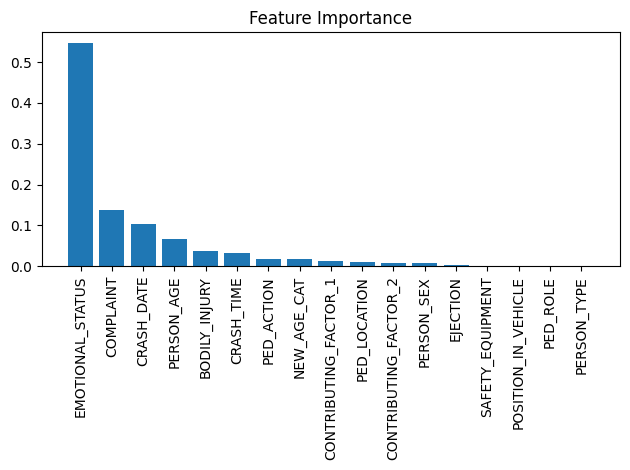

In [18]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()